In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_validate, ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

%matplotlib inline

#DummyRegressor
#SimpleImputer

# Agreed upon cleaned dataset

In [144]:
dataset = pd.read_csv('data/kc_house_data.csv')

# Null waterfront values count as no waterfront
dataset['waterfront'] = dataset['waterfront'].fillna(0) 

dataset['date'] = pd.to_datetime(dataset['date'])
# Drop how many times house viewed
dataset.dropna(subset = ['view'], inplace = True)
# Make values with no house renovation the year it was built
dataset.yr_renovated.fillna(dataset.yr_built, inplace=True)
# Make Zipcode a str
dataset['zipcode'] = dataset['zipcode'].apply(str)
# Make sqft basement a float and fill na with 0
dataset['sqft_basement'] = dataset['sqft_basement'].replace('?', np.nan).astype(float).fillna(0)


In [160]:
#Load in data
df_train = pd.read_csv('data/kc_house_data.csv') 
df_test = pd.read_csv('data/kc_house_data.csv')
df = pd.read_csv('data/kc_house_data.csv')


df['beds_baths'] = df['bedrooms'] + df['bathrooms']
df['waterfront'] = df['waterfront'].fillna(0)
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan).astype(float).fillna(0)
df['zipcode'] = df['zipcode'].apply(str)
df = df.drop(['id','date','view'],axis=1)
df.yr_renovated.fillna(df.yr_built, inplace=True)


# Create a Dummy Dataframe then join to our main one

In [162]:

dummy_df = dataset['grade']
dummies = pd.get_dummies(dummy_df,prefix='grade',drop_first=True)
merged = pd.concat([dataset,dummies],axis=1)
merged.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
grade_4          0
grade_5          0
grade_6          0
grade_7          0
grade_8          0
grade_9          0
grade_10         0
grade_11         0
grade_12         0
grade_13         0
dtype: int64

# A look at how data is distributed

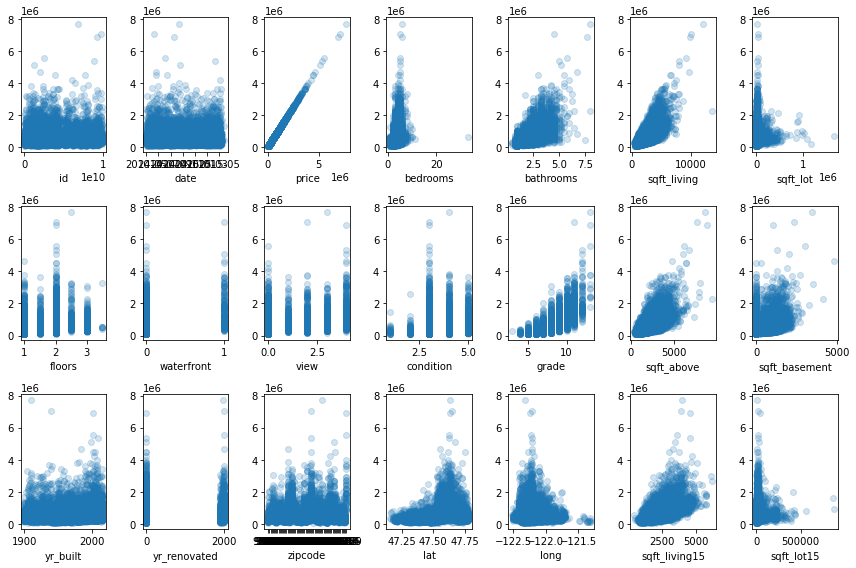

In [167]:
fig , axes = plt.subplots(nrows=3,ncols=7,figsize=(12,8))
fig.set_tight_layout(True)

for index,col in enumerate(dataset.columns):
    ax = axes[index//7][index%7]
    ax.scatter(dataset[col],dataset['price'],alpha=.2)
    ax.set_xlabel(col)

# Heatmap for a quick look at where we might start

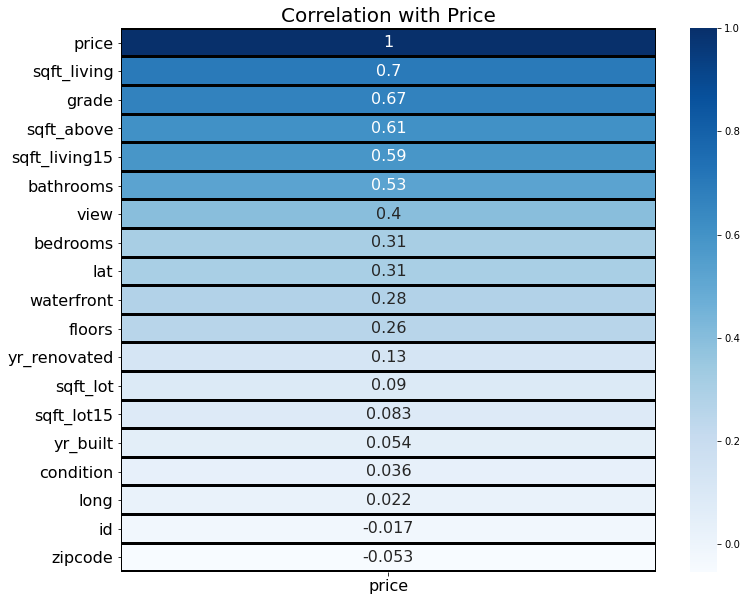

In [168]:
corr = df_train.corr()

x=corr[['price']]

fig , ax = plt.subplots(figsize=(12,10))

sns.heatmap(x.sort_values(by=['price'],ascending=0),
                          annot=True,
                          cmap='Blues',
                          annot_kws={'fontsize':16},
                          linewidth=2,
                          linecolor='black')
ax.set_title('Correlation with Price',size=20)
ax.tick_params(labelsize=16)
                          


 It seems like sqft_living has the highest correlation with price. This and grade seem to be the two highest, but grade is categorical (technically) and sqft is numerical.

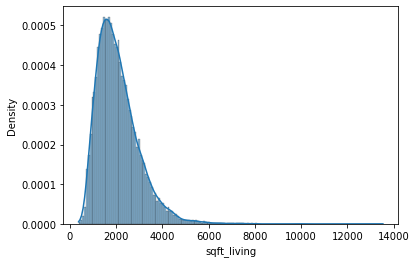

In [6]:
sns.histplot(df['sqft_living'],stat='density',kde=1);


Our data is skewed to the left.

In [63]:
df_zip = df.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
new_df = pd.DataFrame(df_zip,columns=columns)
new_df.head(20)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
zipcode,,,,,,,,,
98039,2.161300e+06,4.060000,3.200000,3800.900000,17403.560000,3.480000,9.560000,3132.200000,17291.100000
98004,1.356524e+06,3.854890,2.527603,2909.022082,13104.220820,3.495268,8.687697,2674.700315,12805.022082
98040,1.194874e+06,4.028369,2.716312,3106.833333,13704.464539,3.787234,8.960993,2898.744681,12801.283688
98112,1.096239e+06,3.509294,2.373606,2498.743494,4990.431227,3.516729,8.442379,2280.078067,4898.159851
98102,8.996077e+05,3.250000,2.283654,2151.048077,3605.153846,3.375000,8.298077,1954.471154,3303.500000
98109,8.800778e+05,3.192661,2.158257,2054.779817,3621.082569,3.477064,8.018349,1928.348624,3605.724771
98105,8.632289e+05,3.580786,2.159389,2150.576419,5121.165939,3.628821,7.838428,2028.624454,4939.017467
98006,8.599386e+05,3.841365,2.555723,2888.295181,13383.435743,3.658635,8.795181,2785.612450,12159.959839
98119,8.497148e+05,3.260870,2.224185,2005.614130,3615.217391,3.375000,8.021739,1865.434783,3727.494565


In [185]:
df_grade = df.groupby('grade').mean().sort_values(by=['price'],ascending=False)
grade_df = pd.DataFrame(df_grade,columns=columns)
grade_df


,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
grade,,,,,,,,,
13,3.710769e+06,4.846154,5.096154,7483.076923,28204.769231,3.153846,NaN,4005.384615,25529.461538
12,2.202528e+06,4.269663,4.025281,5479.022472,54819.213483,3.213483,NaN,3955.988764,39134.078652
11,1.497792e+06,4.160401,3.501880,4395.448622,38372.789474,3.195489,NaN,3532.110276,27743.160401
10,1.072347e+06,3.907407,3.006393,3520.299824,28191.063492,3.232804,NaN,3036.892416,21334.663139
9,7.737382e+05,3.773231,2.664340,2868.139962,20638.515488,3.266157,NaN,2613.460038,17401.707839
8,5.429868e+05,3.481616,2.348928,2184.803627,13514.009068,3.355647,NaN,2067.075845,11371.257049
7,4.025946e+05,3.258079,1.829953,1689.514932,11769.877089,3.491420,NaN,1679.280254,10615.995988
6,3.019166e+05,2.685967,1.243499,1191.561335,12646.953876,3.539745,NaN,1389.247301,11020.924926
3,2.620000e+05,1.000000,0.750000,520.000000,12981.000000,5.000000,NaN,1340.000000,12233.000000


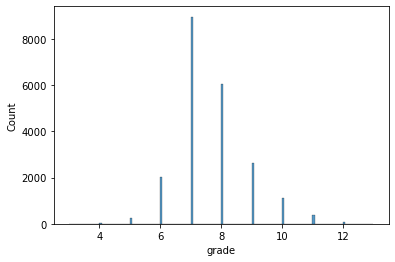

In [91]:
sns.histplot(df['grade']);

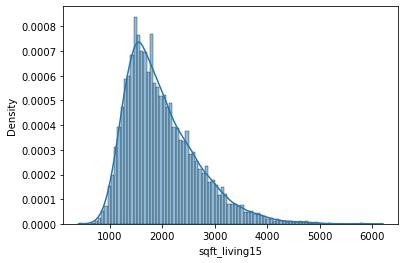

In [92]:
sns.histplot(df['sqft_living15'],stat='density',kde=1);

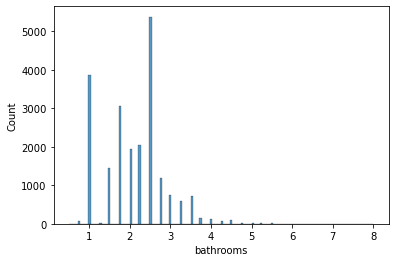

In [93]:
sns.histplot(df['bathrooms']);

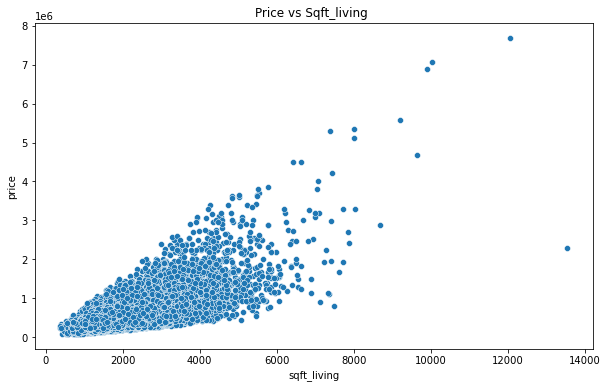

In [94]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Sqft_living ')
sns.scatterplot(x=df['sqft_living'],y=df['price']);

Price and sqft_living seem to have a linear relationship based on this data.

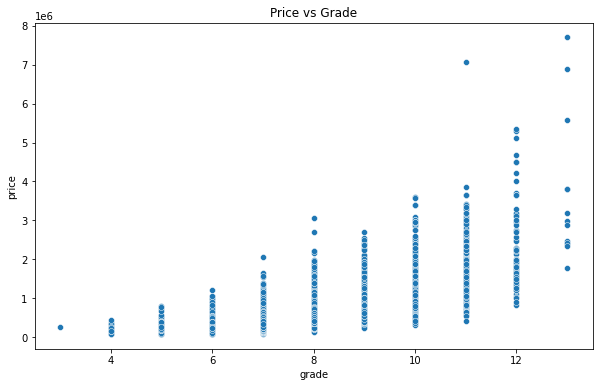

In [95]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Grade')

sns.scatterplot(x=df['grade'],y=df['price']);

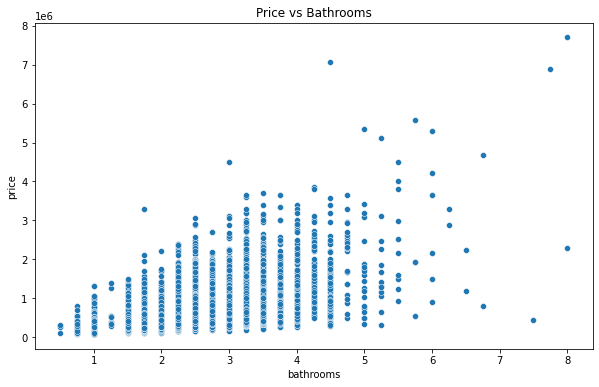

In [96]:
fig , (ax) = plt.subplots(figsize=(10,6))
ax.set_title('Price vs Bathrooms')

sns.scatterplot(x=df['bathrooms'],y=df['price']);

# Looking at score with most correlated feature

In [209]:
X = df['sqft_living']
y = df['price']


dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X,y)
dummy_regr.predict(X)
dummy_regr.score(X,y)

0.0

In [210]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array(X_train).reshape(-1,1)
Y_train = np.array(Y_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


model = LinearRegression()
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

model.coef_,model.intercept_,model.score(X_train,Y_train),metrics.r2_score(Y_pred,Y_test)

(array([[282.20150555]]),
 array([-46447.34551807]),
 0.49249290659878187,
 0.02163804095839439)

In [88]:
formula = 'price ~ sqft_living + beds_baths +  grade_5 + grade_6 +  grade_8 + grade_9 +grade_10+grade_11+grade_12+grade_13' 
model = ols(formula, data=merged)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     3027.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        09:33:52   Log-Likelihood:            -2.9793e+05
No. Observations:               21597   AIC:                         5.959e+05
Df Residuals:                   21586   BIC:                         5.960e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.861e+05   7244.692     25.690      0.000    1.72e+05       2e+05
sqft_living   180.2947      3.595     50.152      0.000     173.248     187.341
beds_baths  -1.735e+04   1732.685    -10.015      0.000   -2.07e+04    -1.4e+04
grade_5     -5.411e+04   1.56e+04     -3.467      0.001   -8.47e+04   -2.35e+04
grade_6     -3.084e+04   6036.658     -5.109      0.000   -4.27e+04    -1.9e+04
grade_8      6.414e+04   4176.544     15.357      0.000     5.6e+04    7.23e+04
grade_9      1.822e+05   6211.797     29.335      0.000     1.7e+05    1.94e+05
grade_10     3.715e+05   9092.788     40.858      0.000    3.54e+05    3.89e+05
grade_11     6.522e+05   1.44e+04     45.388      0.000    6.24e+05     6.8e+05
grade_12     1.173e+06   2.75e+04     42.590      0.000    1.12e+06    1.23e+06
grade_13     2.348e+06   6.79e+04     34.578      0.000    2.21e+06    2.48e+06
==============================================================================
Omnibus:                    13684.418   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           448993.499
Skew:                           2.539   Prob(JB):                         0.00
Kurtosis:                      24.752   Cond. No.                     9.59e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.59e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our first model uses one feature and can explain 49.2% of price variances. Y= 282.20*sqft - 46447 R2 = 49.2

In [178]:
X = pd.DataFrame(df,columns = ['sqft_living','grade'])
y = df['price']

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X,y)
dummy_regr.predict(X)
dummy_regr.score(X,y)

0.0

In [181]:
X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit(X_train).transform(X_train)

model = LinearRegression()
model.fit(X_train,Y_train)

y_hat = model.predict(X_train)

resid = Y_train-y_hat

Y_pred = model.predict(Scaler.transform(X_test))

model.coef_,model.intercept_,model.score(X_train,Y_train) , metrics.r2_score(Y_pred,Y_test) 


(array([168211.94618026, 119172.30259603]),
 541519.0094345083,
 0.5363690098946963,
 0.1760240478124543)

In [182]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,10.451144,sqft_living
1,10.451144,grade


In [74]:
formula2 = 'price ~ sqft_living + grade '
model = ols(formula2, data=df_train)
model.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.241e+04
Date:                Tue, 24 Aug 2021   Prob (F-statistic):               0.00
Time:                        14:33:43   Log-Likelihood:            -2.9913e+05
No. Observations:               21597   AIC:                         5.983e+05
Df Residuals:                   21594   BIC:                         5.983e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.028e+05   1.33e+04    -45.181      0.000   -6.29e+05   -5.77e+05
sqft_living   184.1215      2.872     64.102      0.000     178.491     189.751
grade        9.925e+04   2247.784     44.155      0.000    9.48e+04    1.04e+05
==============================================================================
Omnibus:                    16960.955   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1005795.090
Skew:                           3.304   Prob(JB):                         0.00
Kurtosis:                      35.773   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our second model uses grade and square feet that gives us a better explanation of variances in price.
*Y= 183.33*sqft + 101962*grade - 621259 
R2 = 54%* 





In [159]:
formula3 = 'price ~ sqft_living + grade + beds_baths + waterfront + condition'
model = ols(formula3, data=df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     6185.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):               0.00
Time:                        11:07:01   Log-Likelihood:            -2.9779e+05
No. Observations:               21597   AIC:                         5.956e+05
Df Residuals:                   21591   BIC:                         5.956e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -7.571e+05   1.72e+04    -43.905      0.000   -7.91e+05   -7.23e+05
sqft_living   208.6055      3.412     61.130      0.000     201.917     215.294
grade        1.065e+05   2140.052     49.748      0.000    1.02e+05    1.11e+05
beds_baths  -3.012e+04   1662.345    -18.118      0.000   -3.34e+04   -2.69e+04
waterfront   8.233e+05   1.97e+04     41.732      0.000    7.85e+05    8.62e+05
condition    6.097e+04   2500.517     24.384      0.000    5.61e+04    6.59e+04
==============================================================================
Omnibus:                    15518.669   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           847671.770
Skew:                           2.890   Prob(JB):                         0.00
Kurtosis:                      33.142   Cond. No.                     2.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# An early model where we are exploring features

In [173]:
X = pd.DataFrame(df,columns = ['sqft_living','grade','beds_baths','condition'])
y = df['price']

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
ss = StandardScaler()
ss.fit(X).transform(X)

model.fit(X,y)

y_hat = model.predict(X_test)

resid = Y_test-y_hat

model.coef_,model.intercept_,model.score(X_train,Y_train), metrics.r2_score(y_hat,Y_test) 


(array([   221.88004064, 107108.18507951, -35141.75985275,  63421.8738075 ]),
 -764874.2248935248,
 0.5584010704736011,
 0.22173037087376313)

This model performed poorly on the test set.

In [177]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,16.657437,sqft_living
1,41.340661,grade
2,31.440462,beds_baths
3,18.052397,condition


In [ ]:
#ss = StandardScaler()
#ss.fit(x)

#transform = ss.transform(x)
#transform

#lr = LinearRegression()
#lr.fit(x,y)

#y_hat = lr.predict(x)

#resid = (y - y_hat)

#plt.scatter(x=range(y_hat.shape[0]),y=resid, alpha=0.1)

In [ ]:
#X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [215]:

#model = LinearRegression()
#model.fit(X_train['sqft_living'],Y_train)
#Y_pred = model.predict(X_test)
#model.coef_ , model.intercept_
#mean_squared_error(Y_test,Y_pred) , mean_squared_error(Y_test,Y_pred,squared=False) 


In [ ]:
y_train_hat = lr.predict(X_train)
mse = mean_squared_error(Y_train,y_train_hat)
rmse = mean_squared_error(Y_train, y_train_hat, squared=False)
score = lr.score(X_train,Y_train)
score

print(f'Evaluate Model Prediction with Training Dataset:')
print('------------------------------------------------')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2: {score}')

In [ ]:
y_test_hat = lr.predict(X_test)
mse_test = mean_squared_error(Y_test,y_test_hat)
rmse_test = mean_squared_error(Y_test,y_test_hat,squared=False)
r2_test = lr.score(X_test,Y_test)

print(f'Evaluate Model Prediction with Testing Dataset:')
print('------------------------------------------------')
print(f'Testing Mean Squared Error: {mse_test}')
print(f'Testing Root Mean Squared Error: {rmse_test}')
print(f'Testing R^2: {r2_test}')

In [100]:
#For each X, calculate VIF and save in dataframe
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif["features"] = X.columns


# R2 score with grades as dummy variables

In [178]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-19201.39762364,  34959.07556429, 118535.1257426 ,  12111.72008105,
         51830.65221899,  36187.88429602,  21426.30850977,   -385.55206722,
        -63952.35561449,   3444.69431589,  79901.3600796 , -13552.47292127,
         23296.45951699,  -7267.3098404 ,  -5494.08136799, -16933.85196787,
        -37889.88030132, -41236.99836574,  -8506.65308848,  31430.66066812,
         58885.49020699,  69383.45292962,  59718.04202592,  32064.18783367]),
 538633.7840599065,
 0.7190219718333826,
 0.729873401221775)

Explaining variances at 73%, this is our best model we have come up with.

# R2 Score with Grade as Normal

In [171]:
X = dataset.drop(['price','id','date','sqft_lot','sqft_above','view'], axis = 1).select_dtypes(exclude = ['object', 'category'])
#X = X.drop(['id','date','sqft_lot','sqft_above'],axis=1)
y=dataset['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-35819.36715207,  34092.27549727, 152948.80028728,   5211.94907281,
         66755.87676672,  18678.27083008, 120751.00714304,  -3767.96052014,
        -80335.93294304,   2615.03472858,  75518.91743985, -18222.40516446,
         30096.00359343,  -5364.27151434]),
 538633.7840599064,
 0.6896724562869414,
 0.6736577458777723)

This model performs lower on the testing set, meaning the dummy variables helped with our R2.

In [143]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,23.449023,bedrooms
1,28.285572,bathrooms
2,36.013075,sqft_living
3,16.542578,floors
4,1.184429,waterfront
5,1.519167,view
6,33.900392,condition
7,142.662167,grade
8,2.593844,sqft_basement
9,7816.006176,yr_built


<AxesSubplot:>

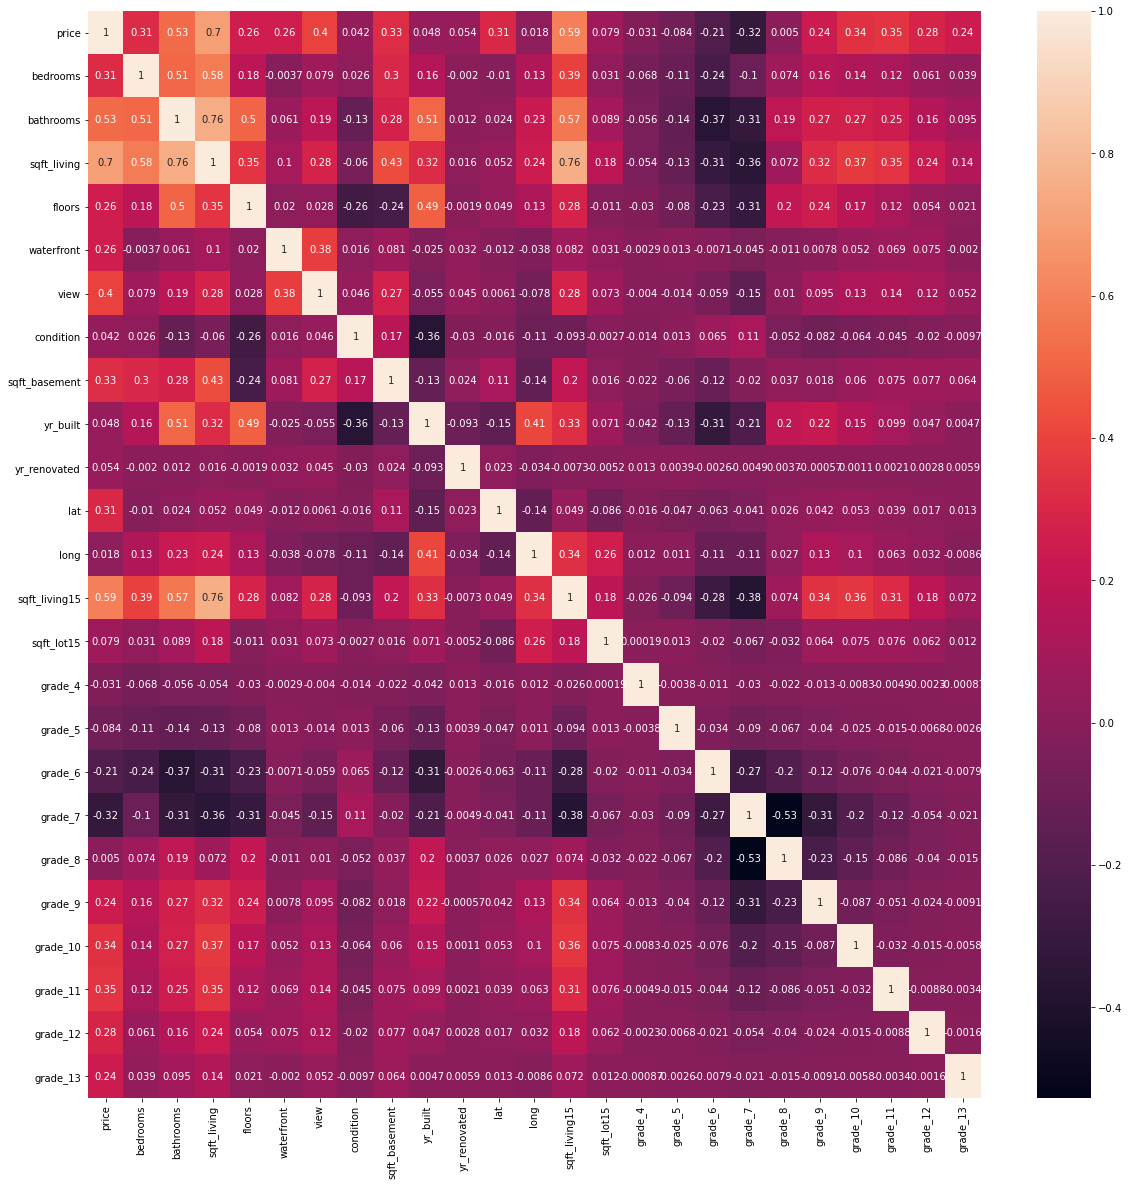

In [179]:
heatmap_data=pd.concat([Y_train,X],axis=1)

fig , ax = plt.subplots(figsize=(20,20))

sns.heatmap(heatmap_data.corr(),annot=True)

In [182]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','sqft_living15','bathrooms','grade_7'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([-14485.54704952, 145599.89081811,  16694.63347087,  51269.2964085 ,
         38813.22632651,  22204.77626046,   1150.13832323, -55388.96824841,
          3948.49571641,  80603.37975438, -10634.32238692,  -7534.89070732,
         -2535.80589932,  -8688.62564074, -16190.08631752,  34543.91831224,
         64750.94661197,  83605.60955683,  85364.31897655,  67449.22275071,
         34669.1373424 ]),
 538633.7840599066,
 0.7149460908443283,
 0.7264230340759208)

In [183]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,23.696966,bedrooms
1,28.880464,sqft_living
2,15.275712,floors
3,1.186719,waterfront
4,1.493807,view
5,33.975159,condition
6,2.536854,sqft_basement
7,7194.944718,yr_built
8,1.293826,yr_renovated
9,118864.640851,lat


In [222]:
X=merged.drop(['price','id','date','sqft_lot','sqft_above','grade','grade_7','sqft_living15','bathrooms','lat','long','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y=merged['price']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
baseline_model.coef_, baseline_model.intercept_, baseline_model.score(X_train, y_train), baseline_model.score(X_test, y_test)

(array([129523.77047686,  50398.73813798,  49971.60629654,  10813.19920769,
        -18848.81998352,  -2512.21721829,  -6535.29035731,  -8135.81347251,
         26648.41162645,  57995.01814726,  82314.86102419,  86358.62262578,
         68723.78186655,  36528.23653218]),
 538633.7840599059,
 0.6227358226048856,
 0.6497688253917169)

In [223]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,4.034729,sqft_living
1,1.183303,waterfront
2,1.384160,view
3,1.248578,yr_renovated
4,1.269302,sqft_lot15
5,1.001180,grade_4
6,1.010111,grade_5
7,1.094216,grade_6
8,1.886023,grade_8
9,1.667251,grade_9
